- In this notebook we summarize the methods to deal with missing values 
- Missing values can happen because of human error, machine sensor malfunction, database failures, etc
- Missing values can reduce the predictive power and lead to biased results if not handled properly.
- There are different solutions for data imputation depending on the kind of the problem  like time series analysis, regression etc. 

![tooth](/images/tooth.jpg)

<!-- TEASER_END -->

### Types of  Missing Values

- Understanding the reasons why data are missing is important for handling the remaining data correctly.
- We need to understand **patterns** and **randomness** of missingness. 
- If values are **missing completely at random**, the data sample is likely still representative of the population. 
- But if the values are **missing systematically**, analysis may be biased.

    
**Missing Completely at Random :**

- The missing data are just a random subset of the data.
- So, there are no systematic differences between the missing and non-missing values. 
- The missing and non-missing values will have **similar distributions**.
- For instance, if data are missing because a researcher dropped the test tubes or survey participants accidentally skipped questions are likely to be Missing Completely at Random.



**Missing at Random**
- Firstly, this name is confusing

- Missing at random means there might be systematic differences between the missing and non-missing values, but these **can be entirely explained by other non-missing features**.

- A better name would actually be `Missing Conditionally at Random`, because the missingness is conditional on another feature(s).  

- For example, if blood pressure data are missing at random, **CONDITIONAL on age and sex**, then the distributions of missing and non-missing blood pressures will be **similar among people of the same age and sex**.

    
 - For better understanding the [difference between Missing Completely at Random and Missing at Random](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4121561/)  
    
**Missing NOT at Random** (Missing with bias):

- The value of the feature that's missing is related to the reason it's missing
- It commonly occurs when people do not want to reveal something very personal or unpopular about themselves. For instance: 
    - People with high salaries generally do not want to reveal their incomes in surveys or 
    - Let’s assume that females generally do not want to reveal their ages! 


- In this case, the missing data mechanism for income is **non-ignorable**. 
- Whether income is missing or non-missing is **related to its value**, not random.

**Effects of Randomness of Missing Data**

- If data are missing not randomly, dropping missing samples and only using complete samples for analysis can give highly biased results. For example,

    - Taking into account the income data, if proportionally more low and moderate income individuals are left in the sample because high income people are missing, an **estimate of the mean income** will be lower than the **actual population mean**.


- So we have to be really careful before removing observations because **systematic biases in data deleted** may produce systematic biases in data retained 

![imputation](/images/imputation.jpg)

### How can we understand if a data is missing at random?
A technique is to create dummy variables for whether a feature which has missing values

- 1 = missing
- 0 = observed

- We can then run **t-tests** and **chi-square** tests between this feature and others in the data set to see if the missingness on this feature is related to the values of others.

- For example, if women really are less likely to tell you their weight than men, a chi-square test will tell you that the **percentage of missing data on the weight variable is higher for women than men.**

# Handling Missing Data

## Detecting Missing Values by Pandas
- `pandas` provides the `isna()` and .`notna()` **functions** to detect the missing values
- They are also **methods** on Series and DataFrame objects
- We can use `pd.isna(df)` or `df.isna()` versions


- `.isna()` can detect `NaN` type of missing values however missing values can be in different forms like `"n/a", "na", "--"`
-  A way dealing this problem is introducing different formats as missing values to pandas during import.



- Here’s an example of how we would do that:

    - Make a list of different missing value formats
    - `missing_values = ["n/a", "na", "--"]` 
    - Pass the list in the `na_values` parameter
    - `df = pd.read_csv("property data.csv", na_values = missing_values)`



- During import pandas will convert those values into `NaN` and recognize when them as missing values with function calls

- You might not be able to catch all of different missing value types right away. 
- As you work through the data and see other types of missing values, you can add them to the list.
- If you count the number of missing values before converting these non-standard types, you could end up missing a lot of missing values.

## Unexpected Missing Values
- We can classify the values that are irrelevant as unexpected missing values
- For example if our feature is expected to be a **categorical**(string, 'Yes' or 'No), but there’s a **numeric value** (say '15'), then technically this is also a missing value.

- We need to think through a strategy for detecting these types of missing values.

- Here’s a solution for our example:
    - Loop through the column with unexpected missing values
    - Try and turn the input into an **integer**. 
    - If the entry can be changed into an integer, replaced it with `NaN`
    - If the number can’t be an integer, we know it’s a string, so keep going


Let’s take a look at the code and then we’ll go through it in detail:

In [ ]:
# Detecting numeric values in a categorical column
cnt=0
for row in df['col_with_unexpected_mv']:
    try:
        # try and change the entry to an integer using int(row)
        int(row)
        # If the value can be converted to an integer, replace to a missing value using Numpy’s np.nan
        df.loc[cnt, 'col_with_unexpected_mv']=np.nan # We can use .iloc() if the index is not a range index
    except ValueError:
        # if it can’t be converted to an integer, we pass and keep going
        pass
    cnt+=1

- to find the missing value percentage of any col, say `col5`:
    - `df['col5'].isna.sum()/len(df)`
    

## Deletion

**Deleting Samples**
- Deletion of any sample if that sample has missing data on any feature

    - can substantially lower the data size
    - can also lead to biased results if the missing data is not missing at random
    - works when there are sufficient data, even though you lost part of your data set and
    - when the missing data are Missing Completely at Random. 
    - can be useful when most values in a column are missing.
    
    
- Still we should first look for the other solutions.

**Deleting Rows With Missing Values**
    
- `missing_samples= df.isna().any()` (finds the rows with missing values)
- `df[missing_samples].dropna(inplace=True)` (deletes the values with missing values)

or directly subset the non-missing values
- `df= df[df.notna()]`


We can keep only ROWs where particular features are NOT null
- `df_no_missing = df[df["col1"].notna() & df["col4"].notna() & df["col6"].notna()]`

**Deleting Features With Missing Values**


-  We can think of dropping the features which have 60% of the samples missing but only if that variable is insignificant. 

- Still we should evaluate well if we could use those features by imputation

In python deleting columns:
- `del df.column_name`
- `df.drop('column_name', axis=1, inplace=True)`

# Imputation
- Deleting the entire rows and/or columns with missing values may cause losing valuable data. 

- A better strategy is to impute the missing values, i.e., fill with the values by infering them from the known part of the data.

- Imputing does not always improve the predictions, so we need to check the performance of models via cross-validation after imputing 

- Sometimes dropping rows or using marker values might be more effective.

- There are many options we could consider when replacing a missing value, for example:
    - A constant value that has meaning within the domain, such as `0`, distinct from all other values.
    - A value from another randomly selected record.
    - A mean, median or mode value for the column.
    - A value estimated by another predictive model.
    


- Filling in the missing values with the **mean** of the features raduces variance in the dataset since we replace unknown values with the central value and produces bias results.
- The **median** is a more robust estimator for data with high magnitude features which could dominate results (known as a ‘long tail’).



- When choosing the imputation methods we neeed to take into account if the dataset is a **timeseries or not**

### Time-Series And Missing Values 

- Time series may not be linear like the temperature over the year. It follows more like a sinusoidal motion, the value is affected by many factors:
    - seasonality, 
    - trend, 
    - other random factors.
    

- We should take into account if there is a trend and seasonality in our timeseries when imputing

- Replacing the missing values with the **mean, median** or **mode** ignores the time series characteristics or relationship between the features. 

## Filling Methods with Pandas

`fillna()` can “fill in” missing values in a couple of ways:
- For example, we can use `fillna()` to replace missing values with the **mean value for each column**, as follows:
    - `df.fillna(df.mean(), inplace=True)`



- Replace NA with a scalar value or  a string: 
    - `df.fillna(0)`, `df.fillna("missing")`


    
- Fill the gaps forward or backward: Using the filling arguments, we can propagate non-NA values forward or backward: 
    - `df.fillna(method='pad')` , `df.fillna(method='ffill')`	fill values forward
       
    - `df.fillna(method='backfill')` bfill / backfill fills values backward
        
    - `ffill()` is equivalent to `fillna(method='ffill')` and 
        
    - `bfill()` is equivalent to `fillna(method='bfill')`
    
## Imputation With Sklearn
- Missing values in the data is incompatible with scikit-learn estimators which assume that all values in an array are numerical
- We can use Sklearn imputing objects by **fit** and **transform** methods
- One advantage of Sklearn imputers is that we can use them in **pipelines**

`from sklearn.impute import SimpleImputer` <br>
`imp = SimpleImputer(missing_values=np.nan, strategy='mean')` <br>
`imp.fit(X)` <br>
`imp.transform(X)` <br>
or we can use `imp.fit_transform(X)` instead of seperate fit and transform

### Marking imputed values

- The `MissingIndicator` transformer of Sklearn is useful to transform a dataset into corresponding **binary matrix** indicating the presence of missing values in the dataset. 

- This transformation is useful in conjunction with imputation. 
- When using imputation, **preserving the information about which values had been missing can be informative**.

- `NaN` is usually used as the placeholder for missing values however, it enforces the data type to be **float**. 
- The parameter `missing_values` allows to specify other placeholder such as **integer**. 

- When using the `MissingIndicator` in a **Pipeline**, be sure to use the `FeatureUnion` or `ColumnTransformer` to add the indicator features to the regular features. 


- `from sklearn.impute import MissingIndicator`
- `indicator = MissingIndicator(missing_values= -1)` # Missing values are marked as -1
- `mask_missing_values_only = indicator.fit_transform(X)`

## Interpolation

Interpolation means using the known (pre-existing) data to infer the values of missing data by using the values on either side of a gap in the data. <br>
Pandas provides a nice selection of simple and more complex interpolation methods. With domain knowledge we can choose which methods to use.

Here are the methods:
- `‘linear’`: Ignore the index and treat the values as equally spaced. 
- `‘time’`: Works on daily and higher resolution data to interpolate given length of interval.
- `‘index’`, `‘values’`: use the actual numerical values of the index.
- `‘pad’`: Fill in `NaN`s using existing values.


- `‘nearest’`, `‘zero’`, `‘slinear’`, `‘quadratic’`, `‘cubic’`, `‘spline’`, `‘barycentric’`, `‘polynomial’`: Passed to `scipy.interpolate.interp1d`. 
   
- `‘krogh’, ‘piecewise_polynomial’, ‘spline’, ‘pchip’, ‘akima’`: Wrappers around the SciPy interpolation methods of similar names. 
- `‘from_derivatives’`: Refers to `scipy.interpolate.BPoly.from_derivatives` 
- For the details of this methods you can check the [Scipy tutorial page](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html) and the [reference guides pages for interpolation](https://docs.scipy.org/doc/scipy/reference/interpolate.html)


Examples:

- `df.interpolate(method='zero')`
![interpolate1](/images/interpolate1.jpg)

- Interpolate **linearly**
- `df.interpolate(method='linear')`
![interpolate2](/images/interpolate2.jpg)

- Interpolate with a **quadratic** function
- `df.interpolate(method='quadratic')`
![interpolate2](/images/interpolate2.jpg)

- As we can see, the method we use for interpolation has a big effect on the outcome.
- For example, linear Interpolation works well for a time series **with some trend** but is not suitable for **seasonal data**

### Template for Interpolation
Since we have the many option to fill-in missing values we can use this tamplate to make an fill-in function. Here we will utilize the `.interpolate()` and `.fillna()` method in the function

In [ ]:
def fill_missing(fill_method='linear', order=2):
    
   # Use interpolation with "spline" and "polynomial" methods. They need order argument
    if algorithm in ['spline', 'polynomial'] :
        df = df.interpolate(method=fill_method, order=order)
    # Use fillna method  
    elif algorithm in ['ffill', 'bfill']:
        df = df.fillna(method=fill_ method)
    else:
        # Use interpolate methods without order argument
        df = df.interpolate(method=fill_method)
        
    return df

### Plot Data Filled With Different Methods
We can see the outcomes of the fill methods by plotting them on one chart. Here is the template:

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()

# List all the methods to be used for filling-in
fill_methods = ['linear', 'quadratic', 'cubic', 'spline', 'polynomial', 'pchip', 'ffill', 'bfill']

# Loop over the methods
for method in fill_methods:
    # Pass in the method in the function fill_missing
    new_df = fill_missing(fill_method='linear', order=2)]
    ax = new_df['ColumnToPlot'].plot()

handles, not_needed = ax.get_legend_handles_labels()
ax.legend(handles, fill_methods, loc='best')

plt.show()

## Adding Dummy Variables
    
- Sometimes missing values are **informative** and **weren't generated randomly**. 

- If they’re **not at random**, the fact that a value is missing is **itself information** and can be expressed as extra binary features.

- It's a good practice to add **binary features** (create a binary flag: missing (1) or not missing (0)) to check if there is missing values in each row for each feature that has missing values. 

- For example, `"feature3"` column has missing values, so we can add a feature `"feature3_missing" ` which takes the values ∈`{0,1}`. 


- While the dummy variable adjustment method is not a proper way when data are truly missing (missing at random), it may still be appropriate in examples like:
    - If someone is not sharing her contact info (missing) it could mean that she is not open to being contacted

    - Married respondents may be asked to rate the quality of their marriage, but that question has no meaning for unmarried respondents. 
    - you might have questions about mother’s education and father’s education, but the father is unknown or was never part of the family. 
    - you might have spouse’s education, but there is no spouse. 
    
- Afterwards we will **check if the the added binary features improve the model or not**. 
- If there is not improvement we can conclude that the features with missing values does not have a pattern

- One disadvantage is if we have many features with missing values it will inflate our feature space drastically

- Here's how it might look:

In [ ]:
# make copy to avoid changing original data (when Imputing)
new_df= original_df.copy()

# Get the columns with missing values
cols_with_missing = (col for col in new_df.columns 
                                 if new_data[col].isnull().any())

# Create new binary columns from the columns with missing values
for col in cols_with_missing:
    new_df[col + '_was_missing'] = new_df[col].isnull()

# Keep the column names
column_names=new_df.columns

# Impute the dataframe 'new_data' with SimpleImputer from Sklearn
my_imputer = SimpleImputer()
new_df = pd.DataFrame(my_imputer.fit_transform(new_df.values))

# Add the column names of the original data
new_df.columns = column_names

- In some cases this approach will meaningfully improve results. In other cases, it doesn't help at all.


- We need to compare the scores of the models by using:
    - a dataset whoose missing values are dropped
    - a dataset whoose missing values imputed 
    - a dataset with extra columns showing what was imputed

### Score of the Dataset with Dropped Missing Values
We can use a template like this get the score from dropped values

In [ ]:
# List the column names with missing values in X_train
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# Drop the columns with missing values from X_train
reduced_X_train = X_train.drop(cols_with_missing, axis=1)

# Drop the columns with missing values from X_test
reduced_X_test  = X_test.drop(cols_with_missing, axis=1)

# Get the score from reduced dataset
print(score(reduced_X_train, reduced_X_test, y_train, y_test))

### Score of the Dataset with Imputed Values 
We can use a template like this get the score from imputed values

In [ ]:
from sklearn.impute import SimpleImputer

# Instantiate the SimpleImputer
my_imputer = SimpleImputer()

# Fit the imputer on the X_train dataset and transform it
imputed_X_train = my_imputer.fit_transform(X_train)

# Transform the X_test
imputed_X_test = my_imputer.transform(X_test)

# Get the score from imputed dataset
print(score(imputed_X_train, imputed_X_test, y_train, y_test))

### Score of the imputed dataset with Extra Columns Showing What Was Imputed

In [ ]:
# Copy the X_train dataset
imputed_X_train_plus = X_train.copy()

# Copy the X_test dataset
imputed_X_test_plus = X_test.copy()

# Get the column names from the X_train with missing values
cols_with_missing = (col for col in X_train.columns 
                                 if X_train[col].isnull().any())

# Create new binary columns from the columns with missing values for X_train and X_test
for col in cols_with_missing:
    imputed_X_train_plus[col + '_was_missing'] = imputed_X_train_plus[col].isnull()
    imputed_X_test_plus[col + '_was_missing'] = imputed_X_test_plus[col].isnull()
    

# Imputate with SimpleImputer
my_imputer = SimpleImputer()

# Fit the imputer on the X_train dataset and transform it
imputed_X_train_plus = my_imputer.fit_transform(imputed_X_train_plus)

# Transform the X_test
imputed_X_test_plus = my_imputer.transform(imputed_X_test_plus)

# Get the score from imputed dataset
print(score_dataset(imputed_X_train_plus, imputed_X_test_plus, y_train, y_test))

### Imputating Using Regression 

- This method assumes the linear relationship between features. 
- It assumes that the value of one features changes in a linear way with the other features. 
- The missing values are replaced by a linear regression function instead of replacing  all  missing  data  with  a  statistics.  

- But  in  most  of  the  cases,  the  relationship  is  not  linear  and  using  regression  imputation in such cases will bias the model.

- We can use the [statsmodel's regression imputation](https://www.statsmodels.org/dev/imputation.html#implementation-details)

### Imputing using K-Nearest Neighbors

- We compute distance between all examples (excluding missing values) in the data set and take the **average of k-nearest neighbors of each missing value** based on some distance measure and number of nearest neighbors.


- There's no implementation for it yet in sklearn and it's pretty inefficient to compute it since we'll have to go through all examples to calculate distances.



- One of the most attractive features of the KNN algorithm is that it is simple to understand and easy to implement. 
- One of the obvious drawbacks of the KNN algorithm is that it becomes time-consuming when analyzing large datasets because it searches for similar instances through the entire dataset. 



- Furthermore, the accuracy of KNN can be severely degraded with high-dimensional(curse of dimensionality) data because there is little difference between the nearest and farthest neighbor.

# Multiple Imputation 

- Instead of substituting missing value with a single value like mean, imputing  by a set of values that better represent each missing value is a smarter idea

- In   Multiple   Imputation   method, for  all  features  having  missing  values  the   process   is   repeated  multiple  times  as  the  name  itself  suggests  

- Multiple imputation follows 3 stages:  **imputation,  analysis**  and  **pooling**
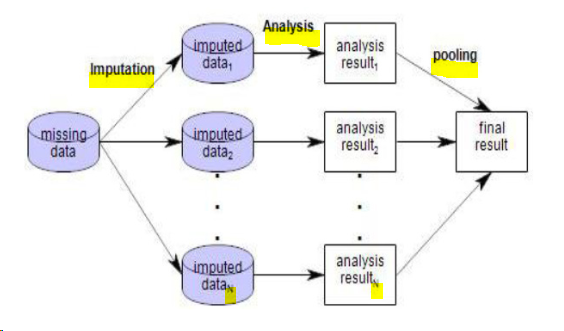

- At the moment MICE can't be used as a transformer in Sklearn pipelines but probably we will be able to use with the next version. Here is the [open issue page](https://github.com/scikit-learn/scikit-learn/issues/11259)



#### Steps:
**Imputation**:
- In  this  step, `N` imputed  datasets  are  generated  from  a  distribution  which  results  in `N`  complete  data  sets.  
- The  distribution can be different for each missing entry.
- The result is **N** imputed datasets. 

**Analysis** 
- Analyze each of `N` completed dataset through pipeline (e.g. feature engineering, clustering, regression, classification).

- Each estimates will differ slightly because the data differs slightly.
- The `N` final analysis results (e.g. held-out validation errors) allows us to understand how analytic results may differ as a consequence of the inherent uncertainty caused by the missing values.

**Pooling**
- The output obtained after data analysis is pooled to get the final result using simple rules.
- Combine results, calculating the variation in parameter estimates.
       
- However, multiple imputation is not always quick or easy. It requires:
    - that the missing data is missing randomly 
    - a very good imputation model 
    - knowing your data very well and having features that will predict missing values.

## Imputation of Train-Test Set and Data Leakage

- Should imputation take place before splitting the dataset or after splitting? 
- If we should impute the train dataset after splitting , how should the validation, test split be imputed?
- There is an interesting discussion on [Kaggle Questions and Answers](https://www.kaggle.com/questions-and-answers/37491) about the possibility of data leakage stemming from imputing 

Sources:<br>
https://scikit-learn.org/stable/modules/impute.html#impute <br>
https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4 <br>
https://www.theanalysisfactor.com/mar-and-mcar-missing-data/ <br>
https://www3.nd.edu/~rwilliam/stats2/l12.pdf <br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/ <br>
https://stats.stackexchange.com/questions/358443/handling-nas-in-a-regression-data-flags <br>
https://stats.stackexchange.com/questions/144924/missing-data-and-imputation-in-general <br>
http://www.indjst.org/index.php/indjst/article/viewFile/110646/80197 <br>
https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b <br>
https://www.kaggle.com/dansbecker/handling-missing-values <br>
http://jmlr.csail.mit.edu/papers/volume8/saar-tsechansky07a/saar-tsechansky07a.pdf